In [2]:
%matplotlib inline

from collections import namedtuple
import logging
import time
from typing import Union, Tuple

import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from scipy.optimize import curve_fit
from sklearn.model_selection import ParameterGrid

CallableArg = Union[float, np.ndarray]
Result = namedtuple("Result", "error hyperparams params")
np_dtype = np.float32

In [3]:
def configure_logging(logging_level) -> logging.Logger:
    """Configures logging module."""
    logger = logging.getLogger("LM-log")
    logger.setLevel(logging_level)
    handler = logging.StreamHandler()
    formatter = logging.Formatter("%(asctime)s.%(msecs)03d: [%(levelname)s] %(message)s")
    formatter.datefmt = "%y-%m-%d %H:%M:%S"
    formatter.converter = time.gmtime
    handler.setFormatter(formatter)
    logger.addHandler(handler)

    return logger

In [4]:
def func_easy(x: CallableArg, a: float, b: float) -> CallableArg:
    """Function exp(ax + b).

    Called easy because it's expected to be fit easier.

    Args:
        x (CallableArg): input.
        a (float): function parameter.
        b (float): function parameter.

    Returns:
        out (CallableArg): output.
    """
    out = np.exp(a * x + b)

    return out


def func_hard(x: CallableArg, a: float, b: float):
    """Function exp(ax + b).

    Called easy because it's expected to be fit harder.

    Args:
        x (CallableArg): input.
        a (float): function parameter.
        b (float): function parameter.

    Returns:
        out (CallableArg): output.
    """
    out = a * np.cos(b * x) + b * np.sin(a * x)

    return out


In [5]:
def calc_jacobian(func, x: np.ndarray, params: np.ndarray, delta: float = 1e-8):
    """Calculates Jacobian matrix numerically in the given point.

    Args:
        func (Callable): calculates Jacobian for this function.
        x (np.ndarray): data points.
        params (np.ndarray): parameters to be updated.
        delta (float): difference value (i.e. dx).

    Returns:
        J (np.ndarray): Jacobian matrix.
    """
    m = x.shape[0]
    n = params.shape[0]

    J = np.zeros((m, n), dtype=np_dtype)
    for i in range(m):
        for j in range(n):
            delta_j = np.zeros_like(params)
            delta_j[j] = delta
            delta_params = params + delta_j

            # calculates [f(x + dx) - f(x)] / dx
            diff = func(x[i], *delta_params) - func(x[i], *params)
            J[i, j] = diff / delta

    return J

In [6]:
def calc_error(func, x: np.ndarray, y: np.ndarray, params: np.ndarray) -> float:
    """Calculates residuals for the given function and parameters.

    Args:
        func (Callable): function that fits the curve.
        x (np.ndarray): data points.
        y (np.ndarray): target values.
        params (np.ndarray): parameters to be updated.

    Returns:
        error (float): sum of squared residuals.
    """
    r = y - func(x, *params)
    error = np.sum(np.power(r, 2))

    return error

In [7]:
def run_single_iteration(func, x: np.ndarray, y: np.ndarray, params: np.ndarray, lmbd: float) -> Tuple[np.ndarray, float]:
    """Runs single-update iteration and calculates error.

    Args:
        x (np.ndarray): data points.
        y (np.ndarray): target values.
        params (np.ndarray): parameters to be updated.
        lmbd (float): LM parameter.

    Returns:
        params_upd, curr_error (tuple): updated parameters and error.
    """
    m = params.shape[0]

    # (J.T @ J + lmbd * I) @ params = J.T @ r
    J = calc_jacobian(func, x, params)
    A = J.T @ J + lmbd * np.eye(m)
    r = y - func(x, *params)
    b = J.T @ r

    params_delta = linalg.solve(A, b)
    params_upd = params + params_delta
    curr_error = calc_error(func, x, y, params_upd)

    return params_upd, curr_error


In [8]:
def levenberg_marquardt(func, x: np.ndarray, y: np.ndarray, init_params: np.ndarray, init_lmbd: float,
                        logger: logging.Logger, num_iters: int = 100, lmbd_inc: float = 11, lmbd_dec: float = 9,
                        lmbd_cap: float = 1e7, error_tol: float = 1e-5) -> np.ndarray:
    params = np.copy(init_params)
    lmbd = init_lmbd

    num_iters_len = len(str(num_iters)) - 1
    for curr_iter in range(num_iters):
        params, curr_error = run_single_iteration(func, x, y, params, lmbd)
        logger.debug(f"Current iteration {curr_iter:>{num_iters_len}}: error={curr_error:.5f} lmbd={lmbd:.5f}")

        if curr_error < error_tol:
            logger.warning("Error is lower than the threshold. Early stopping engaged.")
            return params

        # updating lambda parameter as suggested in the (1)
        _, error_same_lmbd = run_single_iteration(func, x, y, params, lmbd)
        smaller_lmbd = lmbd / lmbd_dec
        _, error_smaller_lmbd = run_single_iteration(func, x, y, params, smaller_lmbd)
        if error_same_lmbd > curr_error and error_smaller_lmbd > curr_error:
            larger_lmbd = lmbd * lmbd_inc
            _, error_larger_lmbd = run_single_iteration(func, x, y, params, larger_lmbd)
            while error_larger_lmbd > curr_error and larger_lmbd < lmbd_cap:
                larger_lmbd = larger_lmbd * lmbd_inc
                _, error_larger_lmbd = run_single_iteration(func, x, y, params, larger_lmbd)

            lmbd = min(larger_lmbd, lmbd_cap)
        elif error_same_lmbd < curr_error and error_smaller_lmbd > curr_error:
            lmbd = lmbd
        elif error_same_lmbd > curr_error and error_smaller_lmbd < curr_error:
            lmbd = smaller_lmbd
        elif error_same_lmbd < error_smaller_lmbd:
            lmbd = lmbd
        else:
            lmbd = smaller_lmbd

    return params

In [9]:
plt.rcParams["figure.figsize"] = [12, 8]

logger = configure_logging(logging.INFO)
num_samples = 100

22-08-16 14:34:32.639: [INFO] scipy: [99.98361908 99.99172993]
22-08-16 14:34:32.641: [INFO] hyperparams: {'init_lmbd': 0.0001}
22-08-16 14:34:33.768: [INFO] hyperparams: {'init_lmbd': 0.025075}
22-08-16 14:34:34.832: [INFO] hyperparams: {'init_lmbd': 0.050050000000000004}
22-08-16 14:34:35.875: [INFO] hyperparams: {'init_lmbd': 0.07502500000000001}
22-08-16 14:34:36.908: [INFO] hyperparams: {'init_lmbd': 0.1}
22-08-16 14:34:37.966: [INFO] optimal hyperparams: {'init_lmbd': 0.1}
22-08-16 14:34:37.967: [INFO] levenberg_marquardt: [99.98361903 99.99172988]


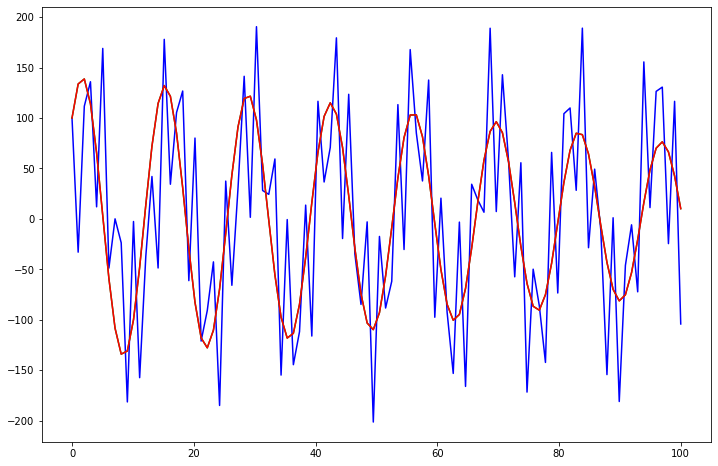

In [10]:
target = lambda x: 100 * np.cos(102 * x) + 102 * np.sin(100 * x)
x = np.linspace(0, 100, num_samples)
y = target(x)
init_params = np.array([100, 100], dtype=np_dtype)

plt.plot(x, y, color="blue")

params_scipy = curve_fit(func_hard, x, y, init_params)[0]
logger.info(f"scipy: {params_scipy}")
plt.plot(x, func_hard(x, *params_scipy), color="green")

hyperparam_grid = ParameterGrid({"init_lmbd": np.linspace(1e-4, 1e-1, 5)})

results = []
for hyperparams in hyperparam_grid:
    logger.info(f"hyperparams: {hyperparams}")
    params = levenberg_marquardt(func_hard, x, y, init_params, logger=logger, **hyperparams)
    curr_error = calc_error(func_hard, x, y, params)
    results.append(Result(curr_error, hyperparams, params))

results = sorted(results, key=lambda res: res.error)
errors = list(map(lambda res: res.error, results))
logger.info(f"optimal hyperparams: {results[0].hyperparams}")

params_lm = results[0].params
logger.info(f"levenberg_marquardt: {params_lm}")
plt.plot(x, func_hard(x, *params_lm), color="red")

22-08-16 14:35:21.485: [INFO] scipy: [0.29518457 0.55037747]
22-08-16 14:35:21.488: [INFO] hyperparams: {'init_lmbd': 0.0001}
22-08-16 14:35:22.332: [INFO] hyperparams: {'init_lmbd': 0.025075}
22-08-16 14:35:23.179: [INFO] hyperparams: {'init_lmbd': 0.050050000000000004}
22-08-16 14:35:24.077: [INFO] hyperparams: {'init_lmbd': 0.07502500000000001}
22-08-16 14:35:24.946: [INFO] hyperparams: {'init_lmbd': 0.1}
22-08-16 14:35:25.804: [INFO] optimal hyperparams: {'init_lmbd': 0.07502500000000001}
22-08-16 14:35:25.806: [INFO] levenberg_marquardt: [0.29518457 0.55037749]


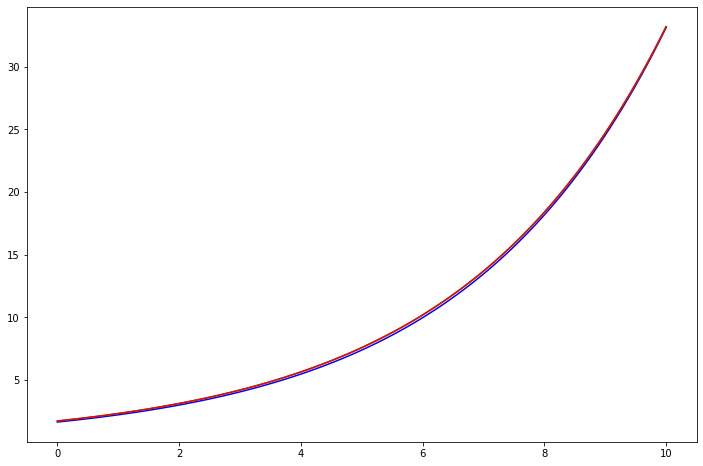

In [14]:
target = lambda x: np.exp(0.3 * x + 0.5)
x = np.linspace(0, 10, num_samples)
noise = np.random.randn(num_samples) * 1.5
y = target(x)
init_params = np.array([1, 1], dtype=np_dtype)

plt.plot(x, y, color="blue")

params_scipy = curve_fit(func_easy, x, y + noise, init_params)[0]
logger.info(f"scipy: {params_scipy}")
plt.plot(x, func_easy(x, *params_scipy), color="green")

hyperparam_grid = ParameterGrid({"init_lmbd": np.linspace(1e-4, 1e-1, 5)})

results = []
for hyperparams in hyperparam_grid:
    logger.info(f"hyperparams: {hyperparams}")
    params = levenberg_marquardt(func_easy, x, y + noise, init_params, logger=logger, **hyperparams)
    curr_error = calc_error(func_easy, x, y + noise, params)
    results.append(Result(curr_error, hyperparams, params))

results = sorted(results, key=lambda res: res.error)
errors = list(map(lambda res: res.error, results))
logger.info(f"optimal hyperparams: {results[0].hyperparams}")

params_lm = results[0].params
logger.info(f"levenberg_marquardt: {params_lm}")
plt.plot(x, func_easy(x, *params_lm), color="red")